In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import os

In [4]:
# Good params on cart-pole from proprio
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_saved_experiments/22-16-45-long_ff_cart/"

DIR = "/home/ira/code/projects/rl_trickery/multirun/2020-06-16/07-41-08/"


In [5]:
runs = os.listdir(DIR)
runs = sorted([int(run) for run in runs if "." not in run])
runs = list(map(str, runs))
runs

['0', '1']

In [29]:
dfs = {}
overrides = {}
configs = {}
for run in runs:
    f_eval = DIR + run + "/eval.csv"
    f_train = DIR + run + "/train.csv"    
    f_config = DIR + run + "/.hydra/config.yaml"    
    f_override = DIR + run + "/.hydra/overrides.yaml"    
    df_run = pd.read_csv(f_eval)
    dfs[run] = df_run
    try:
        with open(f_override) as file:
            overrides[run] = yaml.load(file, Loader=yaml.FullLoader)
    except FileNotFoundError:
        overrides[run] = {}
    try:
        configs[run] = OmegaConf.load(f_config)
    except FileNotFoundError:
        configs[run] = {}
        

In [30]:
scores = {}
for run in runs:
    scores[run] = dfs[run]["episode_reward"].mean()

In [31]:
scores = pd.Series(scores)
scores

0   -0.412260
1   -2.618103
dtype: float64

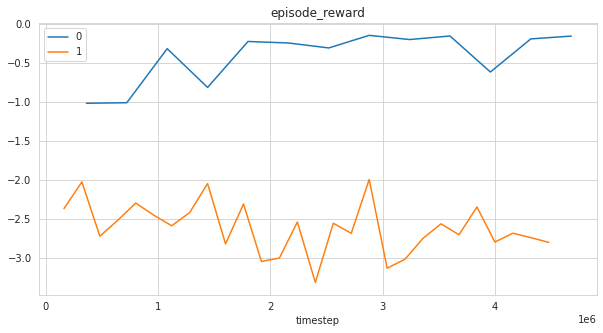

In [32]:
ax = None

target_vars = [
    "episode_reward",
    "loss_entropy",
    "act",
    "fps",
    "episode",
    "value",
]

top_q = 0.0

for target_var in target_vars:
    ax = None
    for key, df in dfs.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df.set_index("timestep")[target_var]
            df = df.rolling(1).mean()
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [33]:
rows = {}
for key, arg in overrides.items():
    row = {}
    if type(arg) is list:
        for s in arg:
            col, val = s.split("=")
            row[col] = val
        rows[key] = (pd.Series(row))
results = pd.DataFrame(rows)
results = results.append(scores.rename("score"))
results = results.T.sort_values("score", ascending=False)
results

,agent,env,seed,agent.num_steps,agent.algo_params.use_timeout,agent.algo_params.optimizer_type,agent.algo_params.lr,agent.algo_params.max_grad_norm,agent.num_envs,agent.network_params.state_channels,score
0,a2c_image,mazelab,500000,12,true,adam,0.001,0.31622776601683794,6,32,-0.41226
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.6181


In [34]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [35]:
overrides

{'0': ['agent=a2c_image',
  'env=mazelab',
  'seed=500000',
  'agent.num_steps=12',
  'agent.algo_params.use_timeout=true',
  'agent.algo_params.optimizer_type=adam',
  'agent.algo_params.lr=0.001',
  'agent.algo_params.max_grad_norm=0.31622776601683794',
  'agent.num_envs=6',
  'agent.network_params.state_channels=32'],
 '1': {}}

In [36]:
for key, config in overrides.items():
    overrides[key] = flatten(config)
results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)
results

AttributeError: 'list' object has no attribute 'items'

In [26]:
for key, config in configs.items():
    configs[key] = flatten(config)
full_results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)
full_results

,num_timesteps,device,seed,num_envs,log_frequency_step,log_save_tb,save_video,eval_frequency_step,num_eval_episodes,env_env_id,...,agent_algo_params_lr,agent_algo_params_gamma,agent_algo_params_value_loss_coef,agent_algo_params_entropy_coef,agent_algo_params_eps,agent_algo_params_alpha,agent_algo_params_max_grad_norm,agent_algo_params_use_timeout,agent_algo_params_optimizer_type,score
0,5e+06,cuda:0,500000,6,100,True,True,5000,16,Mazelab-v0,...,0.001,0.99,0.5,0.01,1e-05,0.99,0.316228,True,adam,-0.56092
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.55533
